# Dynamic Aperture fitting and extrapolation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import sixdesk.da as da
import sixdesk.dist as dist
from sixdesk.da import davst_function, get_fitting_params_distribution, beamloss, get_da_from_fit_output

bl = beamloss()  # load the module to calculate the beam loss

## Perform the fitting

With an existing study load the da vs turn and run the fitting algorithm.

In [3]:
dbname = '/home/phermes/development/SixDeskDB/chrom-20.0-40.0.db'
a = da.davst(dbname,2.2)
_ = a.fit_davst(range(1,61),kappa=np.arange(1,3,0.01))

The fitting parameters and their uncertainties (in standard deviations) are stored in

In [4]:
a.fit.head()

,seed,d,b,k,chisq,std_0,std_1
0,1,4.392015,171.231317,2.99,0.091548,0.055608,2.614204
1,2,4.609369,137.979164,2.99,0.156422,0.071513,3.796358
2,3,4.643647,116.162497,2.99,0.203521,0.086833,4.420606
3,4,3.957665,191.654466,2.99,0.184058,0.096370,4.591939
4,5,4.341812,164.352771,2.99,0.162633,0.076203,3.912524


We can use the davst_function get the DA for a given turn and a given set of fitting parameters:

In [8]:
d,b,k = a.fit[['d','b','k']].iloc[1]

In [9]:
davst_function(10000, d,b,k)

6.7953890972103022

We can also compare the fit to the measurement 

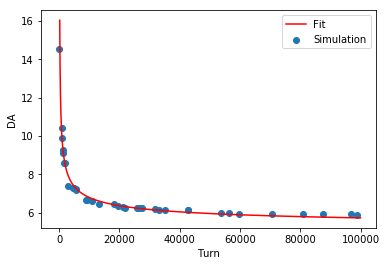

In [10]:
t = np.arange(200, 100000)
simulated_da = a.data[a.data['seed']==2]

plt.plot(t,davst_function(t,d,b,k), 'r-', label='Fit')
plt.scatter(simulated_da['nturn'], simulated_da['dawsimp'], label="Simulation")
plt.xlabel("Turn")
plt.ylabel("DA")
plt.legend()
plt.show()

We can now use the errors from the fitting and assume that the real value for d and b is normally distributed around the main value with the diagonal entries of the covariance matrix being the square of the standard deviation. Instead of using only the 60 seed we can produce alternatives by randomly sampling values for D and b with the aforementioned assumption. Let's produce 1000 realizations for each seed. Resulting in a total of 60000 fitting parameters to consider.

In [106]:
fit_params = get_fitting_params_distribution(a.fit,1000)

In [107]:
len(fit_params)

60000

## Extrapolation
Now we can extrapolate the DA after a given number of turns for the different realizations. Let's start with one realization per seed:

In [109]:
fit_params = get_fitting_params_distribution(a.fit,1)
ex_da      = {}
for j in range(3,9):
    ex_da[j] = get_da_from_fit_output(fit_params, 10**j)

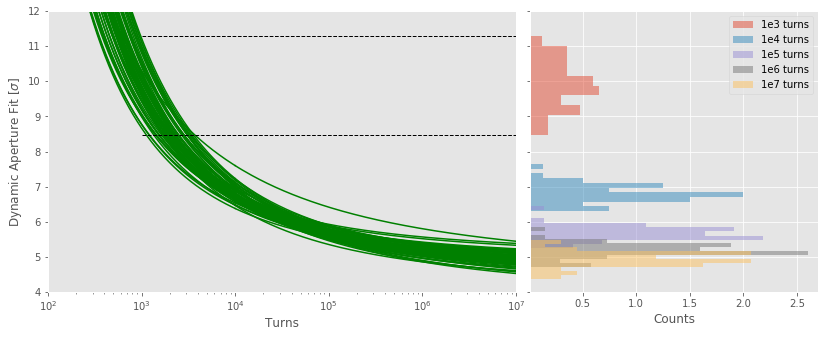

In [110]:
from matplotlib.ticker import NullFormatter

fig = plt.figure(figsize=[10,6])
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.style.use('ggplot')

nullfmt = NullFormatter()         # no labels

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histy = [left_h, bottom, 0.4, height]

# plt.figure(1, figsize=(10, 6))

axdavst = plt.axes(rect_scatter)
axHisty = plt.axes(rect_histy)

axHisty.yaxis.set_major_formatter(nullfmt)

for i in range(0,60):
    d,b,k = a.fit[['d','b','k']].iloc[i]
    t = np.arange(10000, 1e8,1000)
    axdavst.plot(t,davst_function(t,d,b,k), 'g-', label='Fit')
    t = np.arange(100,10000)
    axdavst.plot(t,davst_function(t,d,b,k), 'g-')

for j in range(3,8):
    axHisty.hist(ex_da[j],bins=10,alpha=0.5,label='1e{0} turns'.format(j), orientation='horizontal',normed=True)

axdavst.set_xlim(1e2,1e7)
axdavst.set_ylim(4,12)

axHisty.set_xlabel("Counts")
axHisty.set_xlim(0.01,2.7)
axHisty.set_ylim(axdavst.get_ylim())

axdavst.set_xscale('log')
axHisty.legend()
axdavst.set_xlabel("Turns")
axdavst.set_ylabel(r"Dynamic Aperture Fit [$\sigma$]")

for i in range(3, 4):
    axdavst.plot([10**i, 1e8], [np.min(ex_da[i]), np.min(ex_da[i])], 'k--', lw=1)
    axdavst.plot([10**i, 1e8], [np.max(ex_da[i]), np.max(ex_da[i])], 'k--', lw=1)

axdavst.grid()
plt.show()


Increasing the number of realizations should smear out the result

In [4]:
fit_params = get_fitting_params_distribution(a.fit,20)
ex_da      = {}
for j in range(3,9):
    ex_da[j] = get_da_from_fit_output(fit_params, 10**j)

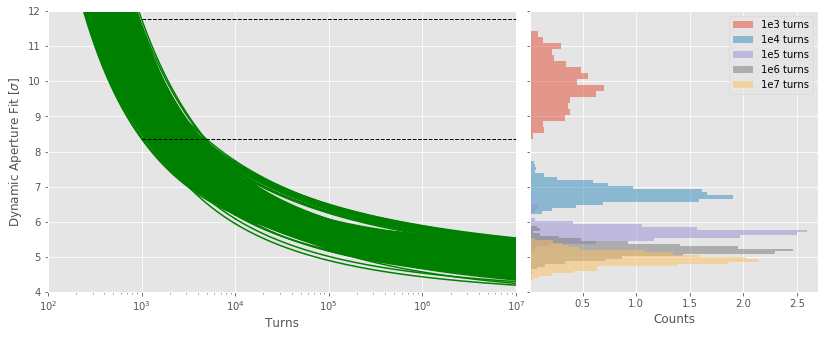

In [6]:
from matplotlib.ticker import NullFormatter

fig = plt.figure(figsize=[10,6])
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.style.use('ggplot')

nullfmt = NullFormatter()         # no labels

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histy = [left_h, bottom, 0.4, height]

# plt.figure(1, figsize=(10, 6))

axdavst = plt.axes(rect_scatter)
axHisty = plt.axes(rect_histy)

axHisty.yaxis.set_major_formatter(nullfmt)

for i in range(len(fit_params)):
    d,b,k = fit_params[['d','b','k']].iloc[i]
    t = np.arange(10000, 1e8,1000)
    axdavst.plot(t,davst_function(t,d,b,k), 'g-', label='Fit')
    t = np.arange(100,10000)
    axdavst.plot(t,davst_function(t,d,b,k), 'g-')

for j in range(3,8):
    axHisty.hist(ex_da[j],bins=20,alpha=0.5,label='1e{0} turns'.format(j), orientation='horizontal',normed=True)

axdavst.set_xlim(1e2,1e7)
axdavst.set_ylim(4,12)

axHisty.set_xlabel("Counts")
axHisty.set_xlim(0.01,2.7)
axHisty.set_ylim(axdavst.get_ylim())

axdavst.set_xscale('log')
axHisty.legend()
axdavst.set_xlabel("Turns")
axdavst.set_ylabel(r"Dynamic Aperture Fit [$\sigma$]")

for i in range(3, 4):
    axdavst.plot([10**i, 1e8], [np.min(ex_da[i]), np.min(ex_da[i])], 'k--', lw=1)
    axdavst.plot([10**i, 1e8], [np.max(ex_da[i]), np.max(ex_da[i])], 'k--', lw=1)

# axdavst.grid()
plt.show()


## Calculation of Beam Loss
With the fitting parameters we can use the loss_from_fit_params method of the beamloss class to get the distribution of possible beam loss:

In [26]:
fit_params = get_fitting_params_distribution(a.fit,200)
loss       = bl.loss_from_fit_params(fit_params, time=12*60*60)

In [27]:
pd.Series(loss).describe()

count    1.790400e+07
mean     1.782414e-02
std      4.059268e-03
min      4.363080e-03
25%      1.505440e-02
50%      1.771830e-02
75%      2.057410e-02
max      4.536320e-02
dtype: float64

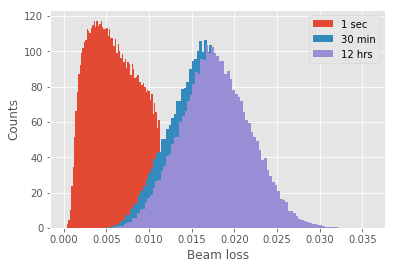

In [25]:
loss       = bl.loss_from_fit_params(fit_params, time=1)
plt.hist(loss,bins=100,normed=True, label='1 sec')

loss       = bl.loss_from_fit_params(fit_params, time=30*60)
plt.hist(loss,bins=100,normed=True, label='30 min')

loss       = bl.loss_from_fit_params(fit_params, time=12*60*60)
plt.hist(loss,bins=100,normed=True, label='12 hrs')

plt.legend()
plt.xlabel("Beam loss")
plt.ylabel("Counts")
plt.show()

Instead of computing new fit parameters with the different realizations, the loss_from_fit_params method allows to parse the number of realizations directly. In that case we can skip the step of calculating the different realizations of the fit_parameters beforehand. Of course now we use the fit parameters for the individiual seeds now: a.fit.

In [33]:
loss       = bl.loss_from_fit_params(a.fit, time=12*60*60, realizations=1000)

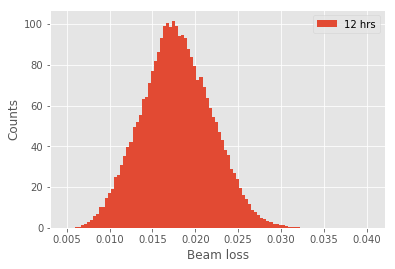

In [34]:
plt.hist(loss,bins=100,normed=True, label='12 hrs')

plt.legend()
plt.xlabel("Beam loss")
plt.ylabel("Counts")
plt.show()

Check how long it takes to calculate the beam loss for different realizations

In [37]:
for realizations in [1, 10, 100, 200, 500, 1000]:
    t0 = time.time()
    loss       = bl.loss_from_fit_params(a.fit, time=12*60*60, realizations=realizations)
    print("{0} Realizations: {1} seconds".format(realizations,time.time()-t0))

1 Realizations: 0.022516250610351562 seconds
10 Realizations: 0.05174517631530762 seconds
100 Realizations: 0.45284605026245117 seconds
200 Realizations: 0.899085283279419 seconds
500 Realizations: 2.2123382091522217 seconds
1000 Realizations: 4.542198896408081 seconds
